## Supervised Siamese Neuronal Network

Import libraries

In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import joblib
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn import metrics

import cv2

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Activation, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt

2023-04-13 17:30:03.573105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 17:30:03.683546: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/carmen/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-13 17:30:03.683565: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-13 17:30:04.376626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerro

Data Loading

In [2]:
# Load the labeled faces in the wild dataset using scikit-learn's fetch_lfw_people function.
faces = fetch_lfw_people(min_faces_per_person=4, resize= 1, color=True, slice_=(slice(15, 235), slice(15, 235)))

# Get the number of unique classes in the dataset by counting the number of unique target names.
class_count = len(faces.target_names)
print(class_count)

610


Example of the images

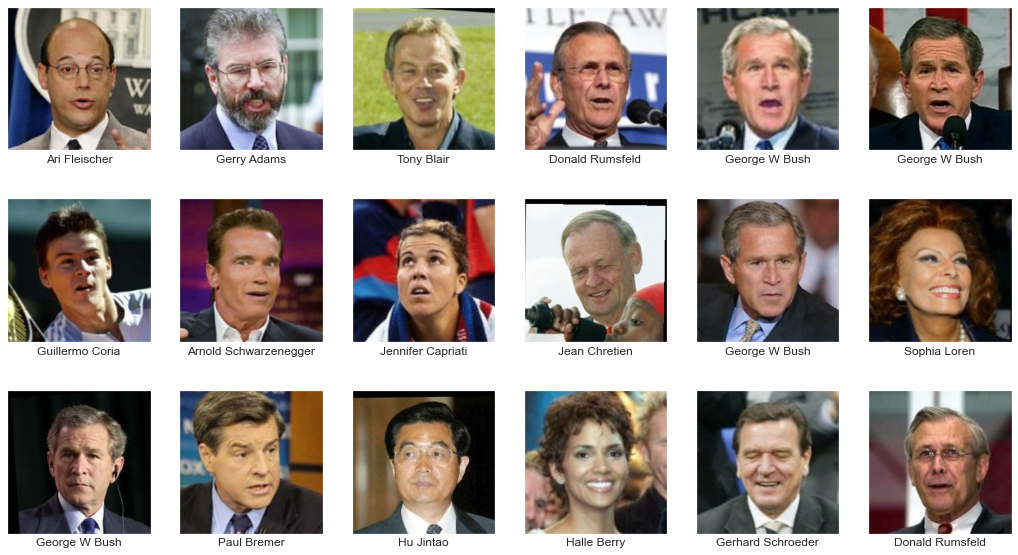

In [3]:
# Create a 3x6 grid of plots to display a sample of the images in the dataset.
sns.set()
fig, ax = plt.subplots(3, 6, figsize=(18, 10))

# For each plot in the grid, show an image from the dataset, scaled to values between 0 and 1 using division by 255.
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255)
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Image pre-processing

In [4]:
# Convert the images and labels to NumPy arrays.
face_images = np.array(faces.images)
face_labels = np.array(faces.target)

# Get the shape of the images in the dataset.
target_shape = face_images[0].shape

# Convert face_images into array
face_images = np.array(face_images, dtype="float32") 

Data Augmentation

In [5]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=0, # Degrees (0 to 180) to randomly rotate images
    horizontal_flip=True, # Randomly flip images horizontally
    zoom_range=0.3, # Range for random zoom (0 to 1)
    fill_mode='nearest', # Strategy for filling in newly created pixels (e.g. when rotating)
    samplewise_center=False, # Whether to center each sample on its mean or on the global mean of the dataset
    brightness_range= [0.5, 1.1], # Change brightness
    rescale=1. / 255 # Convert the pixel values of the images to floating point numbers between 0 and 1.
)


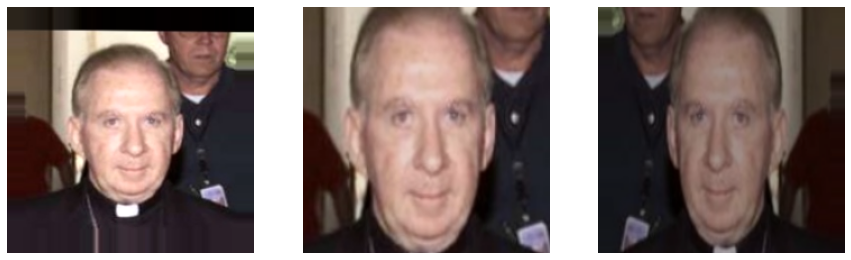

In [6]:
# Creation of an iterator to generate augmented samples from a single image in the dataset
sample = np.random.randint(0,len(face_images))
aug_iter = datagen.flow(face_images[sample].reshape((1,220,220,3)),batch_size=1)

# Plot the original and three augmented samples side by side
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# Generate a batch of 3 images by iterating the augmented data generator 3 times
for i in range(3):

    # Get the next augmented image from the iterator
    image = next(aug_iter)[0]
 
    # Plot the augmented image
    ax[i].imshow(image)
    ax[i].axis('off')

Generation of the pair of images

In [13]:
def generate_image_pairs(images, labels):
    
    """
    This function generates image pairs for training a Siamese Neural Network model.
    
    Parameters:
    images: array-like, shape (n_samples, height, width, channels)
            The images to use for generating the pairs.
    labels: array-like, shape (n_samples,)
            The labels corresponding to each image.
    
    Returns:
    pair_images: array-like, shape (n_pairs, 2, height, width, channels)
                 The generated pairs of images.
    pair_labels: array-like, shape (n_pairs,)
                 The binary labels (0 or 1) corresponding to each pair.
    pair_images_test: array-like, shape (n_pairs_test, 2, height, width, channels)
                      The generated pairs of images for testing purposes.
    pair_labels_test: array-like, shape (n_pairs_test,)
                      The binary labels (0 or 1) corresponding to each test pair.
    """
    
    # Get unique labels in the dataset
    unique_labels = np.unique(labels)

    # Create a dictionary containing a list of indices for each unique label
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    remove_index = []
    get_less_index = []
    
    # Get indices to remove if there are more than 30 images for a label
    # Get indices for labels with less than 5 images to include in testing data
    for value in label_wise_indices.values():
        if len(value) >= 30:
            remove_index.append(value[30:])
        if len(value) < 5:
            get_less_index.append(value[0:5])

    # Flatten the list of indices to remove and the list of indices to get for testing
    merged = list(itertools.chain(*remove_index))
    get_less = list(itertools.chain(*get_less_index))

    # Initialize empty lists for pairs and labels for training data and testing data
    pair_images = []
    pair_labels = []
    pair_images_test = []
    pair_labels_test = []

    for index, image in enumerate(images):

        # Skip image if it needs to be removed
        if index not in merged + get_less:

            # Get indices of images with same label as current image
            pos_indices = label_wise_indices.get(labels[index])

            # Randomly select an image with same label as current image
            pos_image = images[np.random.choice(pos_indices)]

            # Add pair of images and binary label 1 for positive pair
            pair_images.append((image, pos_image))
            pair_labels.append(1)

            # Randomly select an image with different label than current image
            neg_indices = np.where(labels != labels[index])
            neg_image = images[np.random.choice(neg_indices[0])]

            # Add pair of images and binary label 0 for negative pair
            pair_images.append((image, neg_image))
            pair_labels.append(0)
            

        # Add images with less than 5 examples to testing data
        if index in get_less:
           
            pos_indices = label_wise_indices.get(labels[index])

            # Randomly select an image with same label as current image
            pos_image = images[np.random.choice(pos_indices)]

            # Add pair of images and binary label 1 for positive pair to testing data
            pair_images_test.append((image, pos_image))
            pair_labels_test.append(1)

            # Randomly select an image with different label than current image
            neg_indices = np.where(labels != labels[index])
            neg_image = images[np.random.choice(neg_indices[0])]

            # Add pair of images and binary label 0 for negative pair to testing data
            pair_images_test.append((image, neg_image))
            pair_labels_test.append(0)

    # Return numpy arrays for image pairs and binary labels for training and testing data
    return np.array(pair_images), np.array(pair_labels).astype("float32"), np.array(pair_images_test), np.array(pair_labels_test).astype("float32") 


In [8]:
# Generate image pairs from the input images and labels
images_dataset, labels_dataset, images_dataset_test, labels_dataset_test = generate_image_pairs(face_images, face_labels) 

# Shuffle the generated image pairs and corresponding labels
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset) #mezclo para desordenar

# Print the shape of the shuffled image pairs and labels
print(images_dataset.shape, labels_dataset.shape)

(9270, 2, 220, 220, 3) (9270,)


Get train and validation set

In [9]:
# Splitting dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_dataset, labels_dataset, test_size = 0.15, random_state = 17)

# Display the shapes of training data and labels
print(X_train.shape, y_train.shape)

# Check if the training and validation datasets are balanced
lab_train, ocur_train = np.unique(y_train, return_counts=True)
lab_test, ocur_test = np.unique(y_val, return_counts=True)

print(' --- TRAIN --- \nPOSITIVE: ', ocur_train[0], '\nNEGATIVE: ', ocur_train[1])
print(' --- VALIDATION   --- \nPOSITIVE: ', ocur_test[0], '\nNEGATIVE: ', ocur_test[1])

(7879, 2, 220, 220, 3) (7879,)
 --- TRAIN --- 
POSITIVE:  3924 
NEGATIVE:  3955
 --- VALIDATION   --- 
POSITIVE:  711 
NEGATIVE:  680


Visualization of the positive and negative pairs

In [10]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """
    
    # Define a helper function to show an image in a subplot
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Create a figure and subplots for displaying the image pairs
    fig = plt.figure(figsize=(30, 30)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    
    # Iterate over the first n image pairs
    for i in range(n):
        
        # Show the first image of the current pair in the left subplot
        show(axs[i, 0], image_pairs[i][0]/ 255.0)
        
        # Show the second image of the current pair in the right subplot
        show(axs[i, 1], image_pairs[i][1] / 255.0)

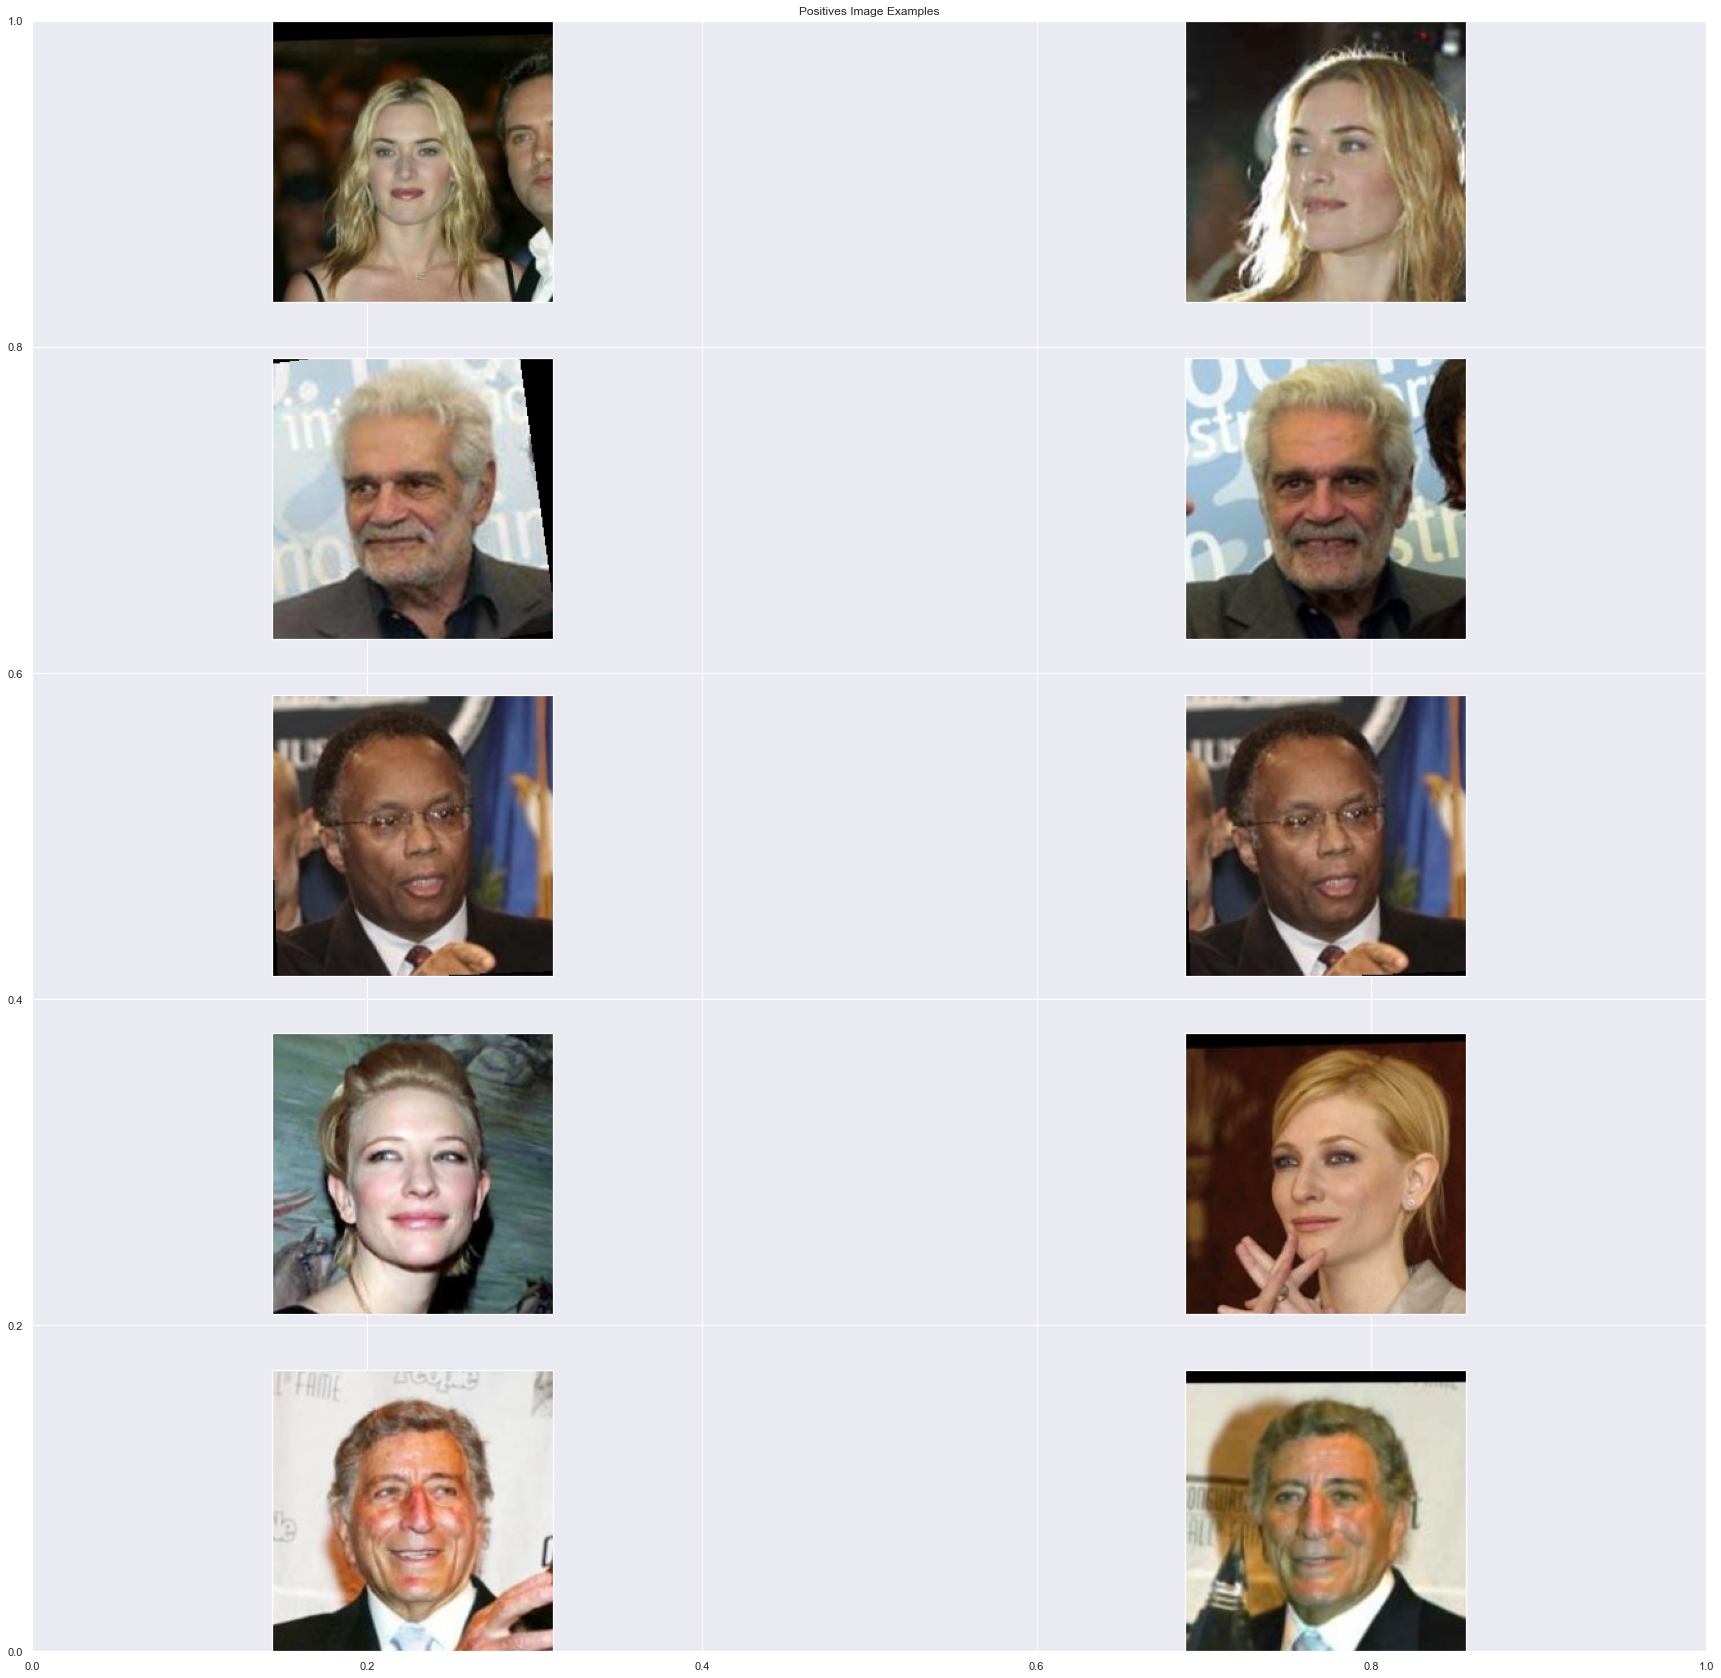

In [11]:
# Positives 
n = 2

# Get sample
indices = np.where(labels_dataset_test == 1)[:n]
visualize(images_dataset_test[indices], labels_dataset_test[indices],
          title = "Positives Image Examples")

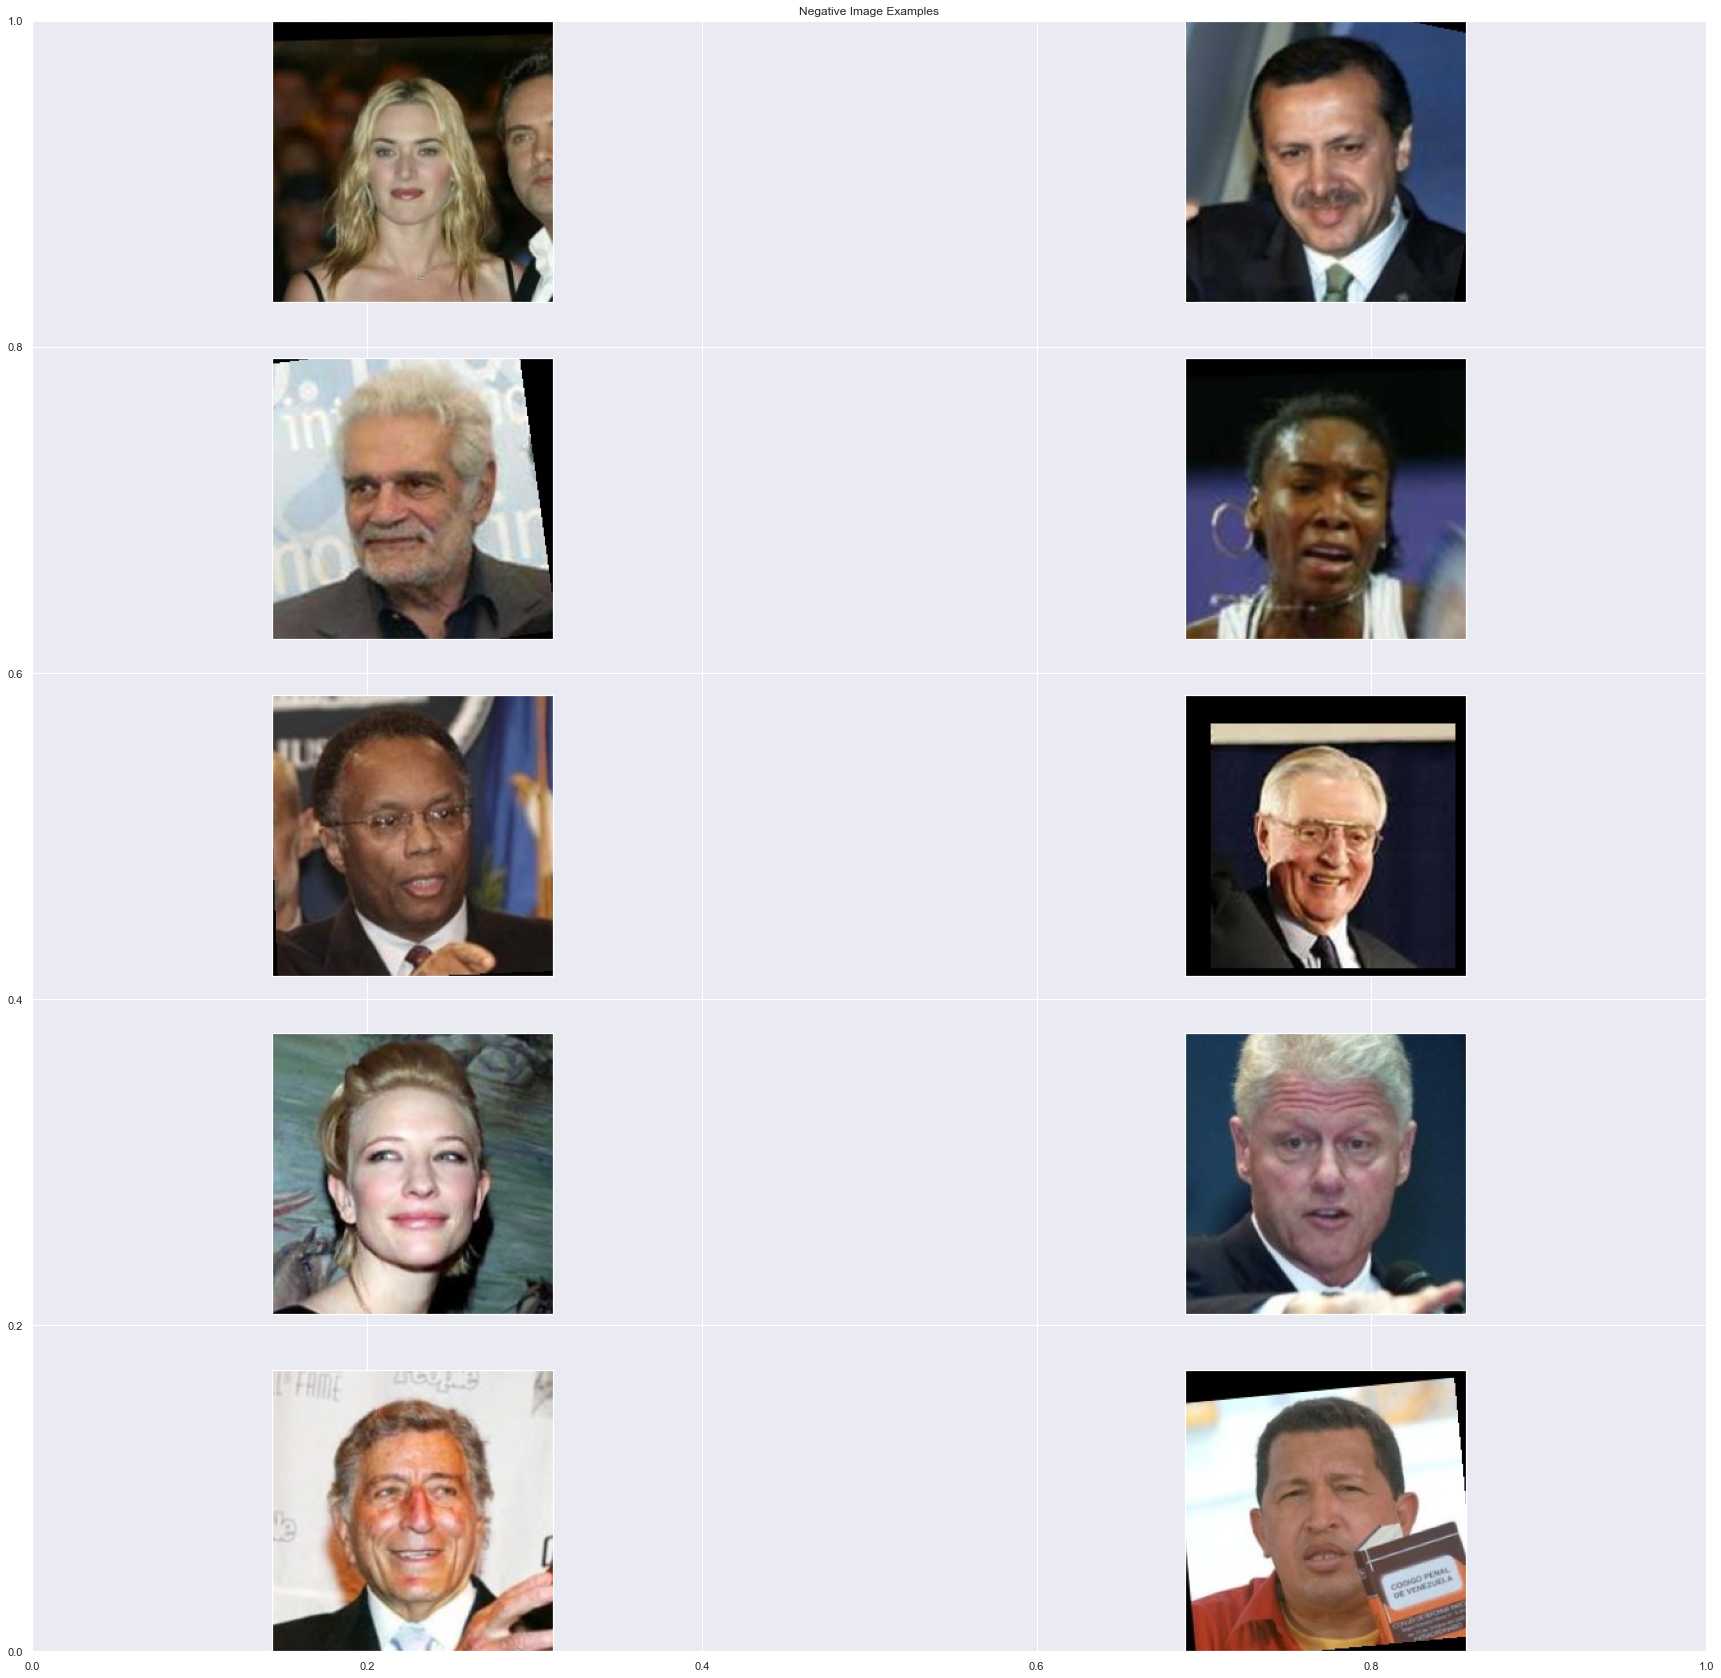

In [12]:
# Negatives
n = 2

# Get samples
indices = np.where(labels_dataset_test == 0)[:n]
visualize(images_dataset_test[indices], labels_dataset_test[indices],
          title = "Negative Image Examples")

Euclidean Distance

In [6]:
def euclidean_distance(vects):
    
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    # Split the list of vectors into two tensors
    x, y = vects

    # Take the square root of the sum of squared differences
    # to get the Euclidean distance between the two vectors
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

Constractive Loss

In [7]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """
        
        # Calculation of the Constractive Loss
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss



In [8]:
def contrastive_loss(y_true, y_pred):
    """Calculates the constrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing constrastive loss as floating point value.
    """

    # Calculation of the Constractive Loss
    
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )

    return contrastive_loss

Model Checkpoints

In [9]:
# Set the value for margin
margin = 1

# Create a ModelCheckpoint callback to save the best model weights during training
# 'accuracy' is monitored, and the best model weights are saved to '.mdl_wts.hdf5' file
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='accuracy', mode='min')

# Create a ReduceLROnPlateau callback to reduce learning rate when the monitored metric stops improving
# 'accuracy' is monitored, and learning rate is reduced by a factor of 0.1 when there is no improvement for 7 epochs
reduce_lr_loss = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

Function to monitorize the training

In [10]:
def plot_graphics(model):
    
    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    
    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(model.history["loss"]) ), model.history["loss"], label="train_loss")
    ax[0].plot(np.arange(0,len(model.history["loss"])), model.history["val_loss"], label="val_loss")
    ax[1].plot(np.arange(0,len(model.history["loss"])), model.history["accuracy"], label="train_acc")
    ax[1].plot(np.arange(0,len(model.history["loss"])), model.history["val_accuracy"], label="val_acc")
    plt.legend()

Siamese network 

In [11]:
def tf_siamese_vgg19_threshold(shape, embedding=64, fineTune=True):
    
    """
    Constructs a Siamese VGG19 model for image comparison.

    Arguments:
        shape: Tuple specifying the input shape of the image.
        embedding: Integer specifying the number of embedding dimensions (default is 64).
        fineTune: Boolean value specifying whether the base model should be fine-tuned or not (default is False).

    Returns:
        A Keras model with specified input shape, output shape and base VGG19 architecture with optional fine-tuning.
    """
    
    inputs = tf.keras.layers.Input(shape)
    
    # Load pre-trained VGG19 model
    base_model = tf.keras.applications.vgg19.VGG19(input_shape=shape, include_top=False, weights='imagenet')
    
    # Freeze base model layers if fineTune=False
    if fineTune==False:
        base_model.trainable=False
    else:
        # Fine-tune base model layers
        base_model.trainable = True
            
    # Add additional layers to base model for classification
    x=base_model(inputs)
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dense(512)(x)
    x=tf.keras.layers.Dropout(.2)(x)
    outputs=tf.keras.layers.Dense(128)(x)
    
    # Construct and return the Keras model
    model = tf.keras.Model(inputs, outputs) 
    return model

# Define inputs for image comparison
img1 = tf.keras.layers.Input(shape= target_shape)
img2 =  tf.keras.layers.Input( shape= target_shape)

# Build feature extractor from Siamese VGG19 model
featureExtractor = tf_siamese_vgg19_threshold(target_shape, 64, True)

# Extract features for image 1 and image 2
featsA = featureExtractor(img1)
featsB = featureExtractor(img2)

# Compute the Euclidean distance between features
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

# Construct output layer for supervised learning
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(distance)

# Construct and return the supervised learning Keras model
model_supervised_threshold = tf.keras.Model(inputs=[img1, img2], outputs=outputs)

2023-04-13 17:30:27.216230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/carmen/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-13 17:30:27.216263: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-13 17:30:27.216280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (labs-ubuntu-20-04): /proc/driver/nvidia/version does not exist
2023-04-13 17:30:27.216491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Training Step

In [99]:
# Compiling the model with contrastive loss, RMSprop optimizer and accuracy as metric
model_supervised_threshold.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])

# Training the model with generated batches of data and validating on validation data, also using ModelCheckpoint and ReduceLROnPlateau callbacks
history_supervised_threshols = model_supervised_threshold.fit(datagen.flow([X_train[:, 0, :], X_train[:, 1, :]], y_train, batch_size = 6), 
                    validation_data=([X_val[:, 0, :], X_val[:, 1, :]], y_val), steps_per_epoch =len(X_train)/6, epochs=14,callbacks=[mcp_save, reduce_lr_loss])

Epoch 1/14
1313/1313 [==============================] - 603s 458ms/step - loss: 0.2342 - accuracy: 0.5980 - val_loss: 0.2079 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 2/14
1313/1313 [==============================] - 600s 457ms/step - loss: 0.2067 - accuracy: 0.6912 - val_loss: 0.1899 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 3/14
1313/1313 [==============================] - 599s 456ms/step - loss: 0.1859 - accuracy: 0.7360 - val_loss: 0.1735 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 4/14
1313/1313 [==============================] - 598s 455ms/step - loss: 0.1683 - accuracy: 0.7653 - val_loss: 0.1690 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 5/14
1313/1313 [==============================] - 601s 458ms/step - loss: 0.1548 - accuracy: 0.7869 - val_loss: 0.1590 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 6/14
1313/1313 [==============================] - 600s 457ms/step - loss: 0.1442 - accuracy: 0.8028 - val_loss: 0.1557 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 7/14
1313/1313 [============

In [ ]:
# Save model
joblib.dump(model_supervised_threshold, 'model_supervised_threshold.pkl')

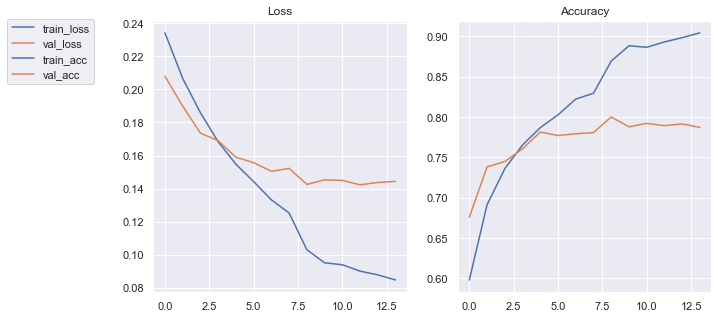

In [196]:
# Plot training history
plot_graphics(history_supervised_threshols)

In [ ]:
model_supervised_threshold = joblib.load('model_supervised_final.pkl')

Training scores

In [16]:
# Calculate Scores of the train data 
scores = model_supervised_threshold.predict([X_train[:, 0, :], X_train[:, 1, :]])

247/247 [==============================] - 501s 2s/step


In [17]:
# Create data frame with the scores
df = pd.DataFrame(list(scores), list(y_train)).reset_index()

# Change columns name 
df.columns = ['true_label','score']

# Calculate tpr, fpr, thresholds
fpr, tpr, thresholds = roc_curve(df.true_label, 
                                 df.score)

In [14]:
# Calculate AUC
metrics.auc(fpr, tpr)

0.7963268396343735

In [21]:
# Create data frame with the roc information
df_roc = pd.DataFrame({'FPR': fpr*100,
                           'TPR': tpr*100,
                           'Threshold': thresholds})

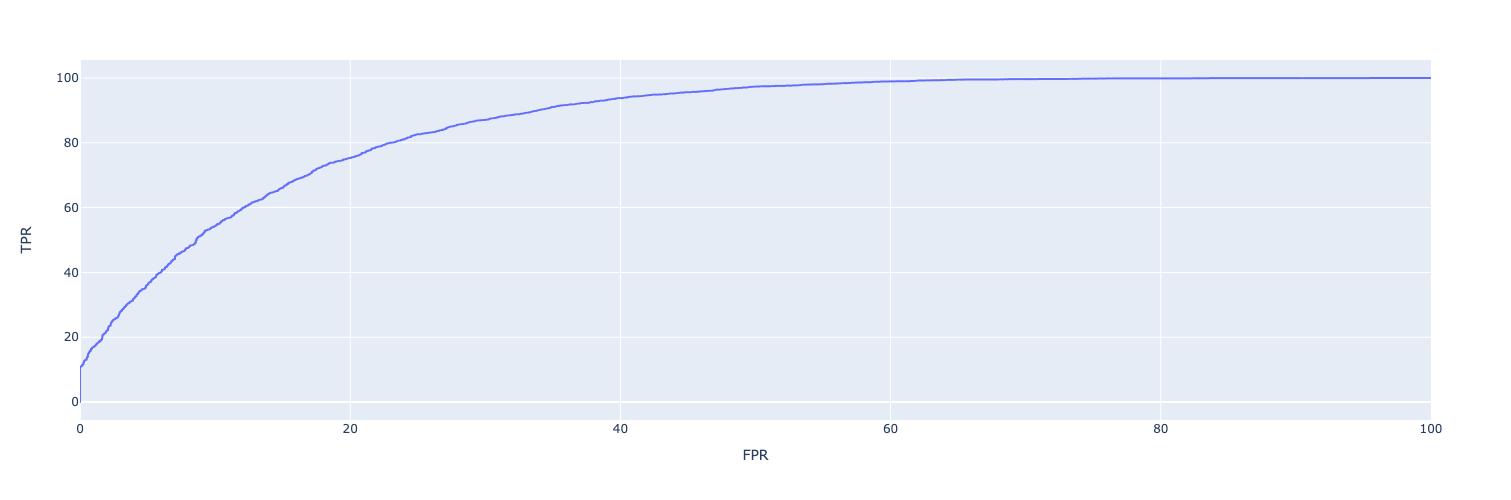

In [32]:
# Plot ROC curve
fig = px.line(df_roc, x='FPR', y='TPR', custom_data={'FPR', 'TPR', 'Threshold'},
                      height=500,  width=500) 

fig.update_traces(mode="lines", 
                   hovertemplate = "Threshold %{customdata[1]:.2f}  <br> TPR %{customdata[2]:.2f}% <br> FPR %{customdata[0]:.2f}%")

Test scores

In [12]:
# Calculate scores for test dataset
scores_test_theshold = model_supervised_threshold.predict([images_dataset_test[:, 0, :], images_dataset_test[:, 1, :]])

47/47 [==============================] - 94s 2s/step


In [13]:
# Creation of a data set with the scores
df_test_theshold = pd.DataFrame(list(scores_test_theshold), list(labels_dataset_test)).reset_index()

In [35]:
# Calculate labels threshold 0.5
df_test_theshold.columns = ['true_label_test','score']
df_test_theshold.loc[df_test_theshold['score'] < 0.5, 'score_50'] = 0
df_test_theshold.loc[df_test_theshold['score'] >= 0.5, 'score_50'] = 1

In [36]:
# Clasification report
print(classification_report(df_test_theshold['true_label_test'], df_test_theshold['score_50']))

              precision    recall  f1-score   support

         0.0       0.79      0.74      0.76       748
         1.0       0.75      0.80      0.78       748

    accuracy                           0.77      1496
   macro avg       0.77      0.77      0.77      1496
weighted avg       0.77      0.77      0.77      1496



In [37]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_test_theshold['true_label_test'], df_test_theshold['score_50'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

552 196 149 599


In [38]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.2620320855614973


In [39]:
# Calculate labels threshold 0.65
df_test_theshold.loc[df_test_theshold['score'] < 0.65, 'score_65'] = 0
df_test_theshold.loc[df_test_theshold['score'] >= 0.65, 'score_65'] = 1

In [40]:
# Clasification report
print(classification_report(df_test_theshold['true_label_test'], df_test_theshold['score_65']))

              precision    recall  f1-score   support

         0.0       0.71      0.85      0.77       748
         1.0       0.81      0.65      0.72       748

    accuracy                           0.75      1496
   macro avg       0.76      0.75      0.75      1496
weighted avg       0.76      0.75      0.75      1496



In [41]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_test_theshold['true_label_test'], df_test_theshold['score_65'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

634 114 259 489


In [42]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.15240641711229946


In [43]:
# Calculate labels threshold 0.8
df_test_theshold.loc[df_test_theshold['score'] < 0.8, 'score_80'] = 0
df_test_theshold.loc[df_test_theshold['score'] >= 0.8, 'score_80'] = 1

In [44]:
# Clasification report
print(classification_report(df_test_theshold['true_label_test'], df_test_theshold['score_80']))

              precision    recall  f1-score   support

         0.0       0.64      0.95      0.76       748
         1.0       0.90      0.45      0.60       748

    accuracy                           0.70      1496
   macro avg       0.77      0.70      0.68      1496
weighted avg       0.77      0.70      0.68      1496



In [45]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_test_theshold['true_label_test'], df_test_theshold['score_80'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

712 36 409 339


In [46]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.0481283422459893


In [47]:
# Calculate labels threshold 0.9
df_test_theshold.loc[df_test_theshold['score'] < 0.90, 'score_90'] = 0
df_test_theshold.loc[df_test_theshold['score'] >= 0.90, 'score_90'] = 1

In [48]:
# Clasification report
print(classification_report(df_test_theshold['true_label_test'], df_test_theshold['score_90']))

              precision    recall  f1-score   support

         0.0       0.58      1.00      0.73       748
         1.0       0.99      0.28      0.44       748

    accuracy                           0.64      1496
   macro avg       0.79      0.64      0.59      1496
weighted avg       0.79      0.64      0.59      1496



In [49]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_test_theshold['true_label_test'], df_test_theshold['score_90'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

746 2 537 211


In [50]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.00267379679144385


Example Image

In [13]:
def generate_image_pairs_pr(images, labels):
    
    """
    This function generates image pairs for training a Siamese Neural Network model.
    
    Parameters:
    images: array-like, shape (n_samples, height, width, channels)
            The images to use for generating the pairs.
    labels: array-like, shape (n_samples,)
            The labels corresponding to each image.
    
    Returns:
    pair_images: array-like, shape (n_pairs, 2, height, width, channels)
                 The generated pairs of images.
    pair_labels: array-like, shape (n_pairs,)
                 The binary labels (0 or 1) corresponding to each pair.
    pair_images_test: array-like, shape (n_pairs_test, 2, height, width, channels)
                      The generated pairs of images for testing purposes.
    pair_labels_test: array-like, shape (n_pairs_test,)
                      The binary labels (0 or 1) corresponding to each test pair.
    """
    
    # Get unique labels in the dataset
    unique_labels = np.unique(labels)

    # Create a dictionary containing a list of indices for each unique label
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    remove_index = []
    get_less_index = []
    
    # Get indices to remove if there are more than 30 images for a label
    # Get indices for labels with less than 5 images to include in testing data
    for value in label_wise_indices.values():
        if len(value) >= 30:
            remove_index.append(value[30:])
        if len(value) < 5:
            get_less_index.append(value[0:5])

    # Flatten the list of indices to remove and the list of indices to get for testing
    merged = list(itertools.chain(*remove_index))
    get_less = list(itertools.chain(*get_less_index))

    # Initialize empty lists for pairs and labels for training data and testing data
    pair_images = []
    pair_labels = []
    pair_images_test = []
    pair_labels_test = []

    for index, image in enumerate(images):

        # Add images with less than 5 examples to testing data
        if index in get_less:
           
            pos_indices = label_wise_indices.get(labels[index])

            # Randomly select an image with same label as current image
            pos_image = images[np.random.choice(pos_indices)]

            # Add pair of images and binary label 1 for positive pair to testing data
            pair_images_test.append((image, pos_image))
            pair_labels_test.append(1)

            # Randomly select an image with different label than current image
            neg_indices = np.where(labels != labels[index])
            neg_image = images[267]

            # Add pair of images and binary label 0 for negative pair to testing data
            pair_images_test.append((image, neg_image))
            pair_labels_test.append(0)

    # Return numpy arrays for image pairs and binary labels for training and testing data
    return np.array(pair_images_test), np.array(pair_labels_test).astype("float32") 


In [14]:
# Generate image pairs from the input images and labels
images_dataset_test_pr, labels_dataset_test_pr = generate_image_pairs_pr(face_images, face_labels) 

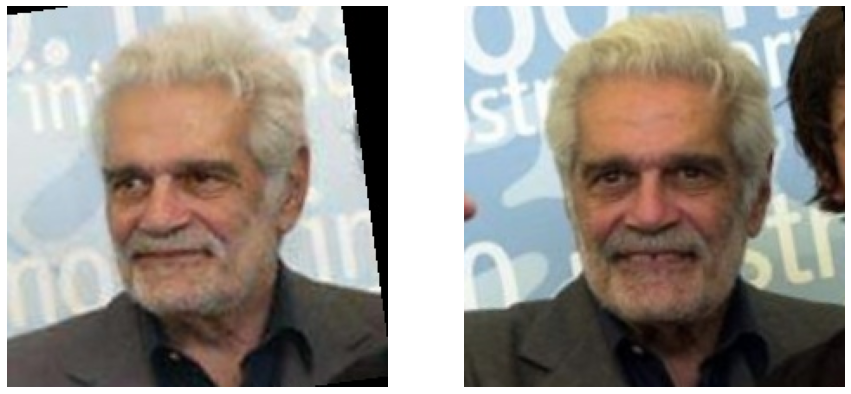

In [15]:
# Plot the original and three augmented samples side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

# Generate a batch of 3 images by iterating the augmented data generator 3 times
for i in range(2):

    # Get the next augmented image from the iterator
    image = images_dataset_test_pr[2][i]
 
    # Plot the augmented image
    ax[i].imshow(image/ 255) 
    ax[i].axis('off')

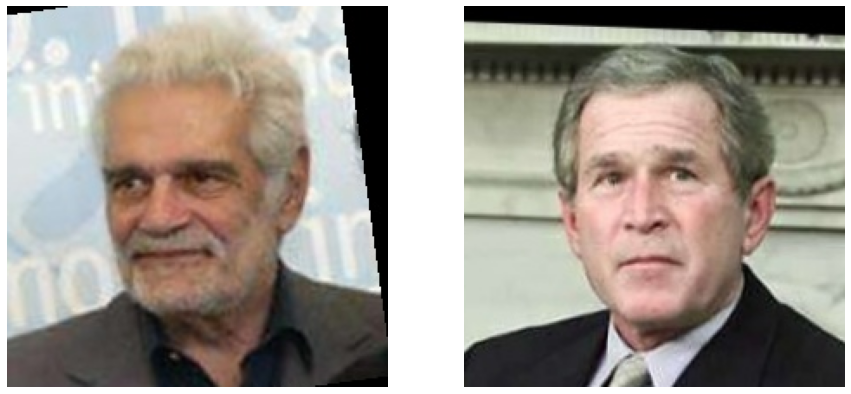

In [16]:
# Plot the original and three augmented samples side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

# Generate a batch of 3 images by iterating the augmented data generator 3 times
for i in range(2):

    # Get the next augmented image from the iterator
    image = images_dataset_test_pr[3][i]
 
    # Plot the augmented image
    ax[i].imshow(image/ 255) 
    ax[i].axis('off')

In [17]:
# Calculate Scores 
scores = model_supervised_threshold.predict([images_dataset_test_pr[:, 0, :], images_dataset_test_pr[:, 1, :]])

47/47 [==============================] - 94s 2s/step


In [33]:
scores[2:4]

array([0.868215, 0.377206])